rework of ch_9_2_first_nns.ipnynb to make cnns  
utilizing csv instead of loading as images   
balanced dataset  
5. 15x20 // CNN 1D // 3 - Live Data vs PerfectFam vs StreakMM

# IMPORTS

In [337]:
import random
import pickle
import glob

import random
import ast
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import matplotlib.transforms as transforms

from collections import Counter

from time import time
from time import sleep
from time import strftime
from time import localtime
from tqdm import tqdm

from datetime import date, timedelta, datetime

# from mydecorators import logger, stopwatch

from PIL import Image



In [338]:
import torch
import torch.nn as nn
import torchvision

import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset

import matplotlib.pyplot as plt



# Read CSV of All Data

In [340]:
df_alldata = pd.read_csv('../combined_dataset.csv')
# display(df_alldata)

In [341]:
df_alldata.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,2,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,2,perfectmm_456_1
2,1,1,1,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,2,perfectmm_456_2
3,1,1,1,1,1,1,1,0,1,0,...,0,1,1,0,0,1,0,1,2,perfectmm_456_3
4,1,0,0,0,0,0,0,1,1,1,...,1,0,0,0,1,0,1,1,2,perfectmm_456_4


# Prepare Dataframes
- Remove Live Data (0)  
- Check Labels ...   
=>  
Live Data : 0  
NearPerfectMM : 1    
PerfectMM : 2  
StreakMM : 3  

In [343]:
df_w_live = df_alldata.copy()

# display(df_wo_live)

## Check current labels

In [345]:
orig_labels = list(df_w_live['labels'])

In [346]:
len(orig_labels)

132127

In [347]:
set(orig_labels)
### 0: live_data
### 1: nearperfectmm
### 2: perfectmm
### 3: streakmm

{0, 1, 2, 3}

## Relabel Accordingly
live_data 0 -> 0  
nearperfectmm 1 -> 1  
perfectmm 2 -> 1   
streakmm 3 -> 2

In [349]:
replaced_labels = [1 if x==2 else x for x in orig_labels]
set(replaced_labels)

{0, 1, 3}

In [350]:
replaced_labels = [2 if x==3 else x for x in replaced_labels]
set(replaced_labels)

{0, 1, 2}

In [351]:
df_w_live['labels'] = replaced_labels

In [352]:
set(df_w_live['labels'])

{0, 1, 2}

## Display Current Dataframe

In [354]:
df_w_live[df_w_live['labels']==0].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
90000,1,1,1,0,1,1,1,0,1,0,...,0,1,1,1,0,1,1,0,0,좋은챔프
90001,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,1,0,진기장판


In [355]:
df_w_live[df_w_live['labels']==0].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
132125,0,0,0,1,1,0,1,1,0,0,...,0,1,0,1,0,1,1,1,0,너가능성잇써
132126,0,1,0,1,0,1,1,0,1,1,...,0,0,0,0,0,1,1,0,0,토꽃


In [356]:
df_w_live[df_w_live['labels']==1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,1,perfectmm_456_1


In [357]:
df_w_live[df_w_live['labels']==1].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
59998,1,0,1,0,1,1,1,1,0,0,...,1,1,0,1,1,1,1,1,1,nearperfectmm_457_998
59999,0,1,1,1,0,0,1,0,0,1,...,1,1,1,0,1,1,0,1,1,nearperfectmm_457_999


In [358]:
df_w_live[df_w_live['labels']==2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
60000,0,1,0,0,0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,2,streakmm_412_0
60001,1,1,1,1,1,1,0,0,0,0,...,0,1,0,1,1,1,1,1,2,streakmm_412_1


In [359]:
df_w_live[df_w_live['labels']==2].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
89998,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,2,streakmm_386_998
89999,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,2,streakmm_386_999


In [360]:
df_w_live[df_w_live['labels']==3].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths


In [361]:
### Live Data
len(df_w_live[df_w_live['labels']==0])

42127

In [362]:
### PerfectMM & NearPerfectMM (PerfectFam)
len(df_w_live[df_w_live['labels']==1])

60000

In [363]:
### StreakMM
len(df_w_live[df_w_live['labels']==2])

30000

## Sample from Groups

### from Live Data

In [366]:
train_livedata = df_w_live[df_w_live['labels']==0].sample(n=20000, random_state=10)

In [367]:
train_livedata.head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
128105,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,0,1,0,오젠트리안
128363,0,0,1,1,0,0,1,0,1,1,...,1,0,0,0,0,1,1,0,0,01수영
121491,0,1,0,0,0,0,1,1,1,1,...,0,0,1,0,1,1,0,1,0,무현스님


### from PerfectFam

In [369]:
train_perfectfam = df_w_live[df_w_live['labels']==1].sample(n=20000, random_state=10)

In [370]:
train_perfectfam.head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
4883,0,0,0,0,1,0,0,1,1,0,...,0,1,1,0,0,0,1,1,1,perfectmm_94_883
28477,0,0,0,0,0,0,1,1,1,0,...,0,1,1,1,0,0,1,1,1,perfectmm_712_477
8527,1,0,0,1,0,1,0,1,0,1,...,0,1,0,0,1,0,0,1,1,perfectmm_999_527


### from StreakMM

In [372]:
train_streakmm = df_w_live[df_w_live['labels']==2].sample(n=20000, random_state=10)

In [373]:
train_streakmm.head(3).head(3)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
80412,1,1,1,1,1,1,1,1,1,0,...,0,1,0,0,0,0,0,0,2,streakmm_4_412
61296,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,2,streakmm_229_296
63906,1,1,1,1,1,1,0,0,0,0,...,1,1,0,0,0,0,1,0,2,streakmm_14_906


### Get df_train (3 dfs into 1)

In [375]:
df_train = pd.concat([train_livedata, train_perfectfam, train_streakmm])

In [376]:
display(df_train.head(3))
print(len(df_train))

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
128105,0,0,0,0,0,0,0,1,0,1,...,1,1,1,1,1,0,0,1,0,오젠트리안
128363,0,0,1,1,0,0,1,0,1,1,...,1,0,0,0,0,1,1,0,0,01수영
121491,0,1,0,0,0,0,1,1,1,1,...,0,0,1,0,1,1,0,1,0,무현스님


60000


### Get df_test

In [378]:
### indices of df_train
train_idx = list(df_train.index)
len(train_idx)

60000

In [379]:
### indices of df_w_live
df_w_live_idx = list(df_w_live.index)
len(df_w_live_idx)

132127

In [380]:
### df_w_live_idx - train_idx
test_idx = list(set(df_w_live_idx)-set(train_idx))
len(test_idx)

72127

In [381]:
df_test = df_w_live.loc[test_idx]
display(df_test.head(3))
display(df_test.tail(3))
print(len(df_test))

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
131072,0,0,0,1,0,1,1,0,1,0,...,1,0,1,0,0,1,1,0,0,히읏차
2,1,1,1,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,1,perfectmm_456_2
3,1,1,1,1,1,1,1,0,1,0,...,0,1,1,0,0,1,0,1,1,perfectmm_456_3


,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
131065,1,1,1,0,1,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,신은없으니깐
131069,0,1,1,1,1,1,0,1,1,0,...,1,0,1,1,0,1,1,1,0,묘목있어요
131071,0,0,0,0,0,1,1,1,0,1,...,0,0,1,0,0,1,1,1,0,민쵸트코


72127


In [382]:
# df = df_w_live[df_w_live['labels']==2].sample(n=1, random_state=11)

In [383]:
# df

In [384]:
# ddf = df_w_live[df_w_live['labels']==2].sample(n=2, random_state=10)

In [385]:
# ddf

In [386]:
# dddf = pd.concat([df,ddf])

In [387]:
# dddf

In [388]:
# dddf.reset_index(drop=True)

In [389]:
# dddf = dddf.reset_index(drop=False)

In [390]:
# dddf 

In [391]:
# sorted(list(dddf.index))

In [392]:
# df_w_live[df_w_live['labels']==2].loc[[61296, 76131, 80412]]

In [393]:
# del dddf

# Create Pytorch Dataset (custom)

## Define Dataset Class

In [396]:
# Custom Dataset Class
## Needs AT LEAST 3 class methods
## __init__, __len__, __getitem__

class RecordsDataset(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self, pd_df):
        # load data
        self.df=pd_df
        # extract labels
        self.df_labels=self.df[['labels']]
        # drop non numeric columns to make tutorial simpler, in real life do categorical encoding
        # self.df=df.drop(columns=['Type','Color','Spectral_Class'])
        
        # convert to torch dtypes
        # self.dataset = self.df[[0,1]]
        # self.dataset=torch.tensor(self.df[[i for i in range(300)]].to_numpy()).float()
        self.dataset=torch.tensor(self.df[[str(i) for i in range(300)]].to_numpy()).float()
        # self.dataset = self.df[[str(i) for i in range(10)]]
        
        self.labels=torch.tensor(self.df_labels.to_numpy().reshape(-1))
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.dataset)
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

## Instantiate Dataset Class

In [398]:
# all_dataset = RecordsDataset(df_w_live)
train_alldataset = RecordsDataset(df_train)

In [399]:
test_alldataset = RecordsDataset(df_test)

## Split Train & Test

In [401]:
# train_size = int(0.7 * len(all_dataset))
# test_size = len(all_dataset) - train_size
# # train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])

# train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(12))
# ### torch.Generator().manual_seed(42)

In [402]:
# train_alldataset
# len(train_alldataset)

In [403]:
# test_alldataset
# len(test_alldataset)

## Create Train & Test all_dataloaders

In [405]:
train_alldataloader = torch.utils.data.DataLoader(train_alldataset, batch_size=32, shuffle=True)

In [406]:
test_alldataloader = torch.utils.data.DataLoader(test_alldataset, batch_size=32, shuffle=False)

### Check Train alldataloader

In [408]:
for images, labels in train_alldataloader:
    break

# images, labels = next(iter(dataloader))

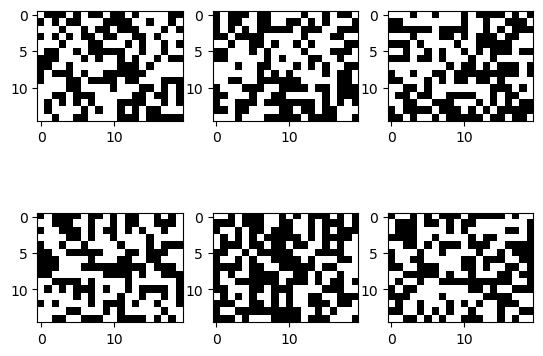

In [409]:
examples = iter(train_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)

# example_data.shape
# example_data[0].reshape(15,20)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [410]:
print(example_targets)

tensor([1, 0, 1, 0, 1, 0, 2, 0, 2, 0, 0, 1, 2, 2, 2, 2, 0, 2, 0, 0, 2, 1, 1, 1,
        0, 0, 0, 2, 0, 2, 2, 1])


### Check Test alldataloader

In [412]:
for images, labels in test_alldataloader:
    break

# images, labels = next(iter(dataloader))

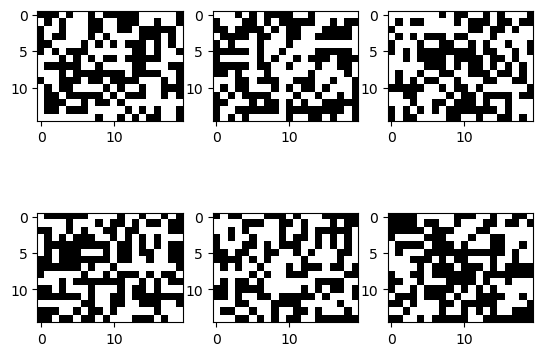

In [413]:
examples = iter(test_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [414]:
print(example_targets)

tensor([0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 1])


# Create First CNN
- Live Data vs (PerfectMM & NearPerfectMM) v StreakMM


## Configurations (Hyperparameters)

In [1925]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyper-parameters
input_size = 15*20 # originally 348x465 before resize

num_classes = 3


# num_epochs = 1
# num_epochs = 2
# num_epochs = 10
# num_epochs = 20
# num_epochs = 50
num_epochs = 100
# num_epochs = 300
# num_epochs = 500
# num_epochs = 1000

learning_rate = 0.0003

In [1926]:
print(device)

mps


## Define Model

In [1928]:
## last layer(linear fc) modified to have more input nodes
### balanced_cnn_1d_4conv_biggerfc2_10epo.pth
### balanced_cnn_1d_4conv_biggerfc2_20epo.pth
### balanced_cnn_1d_4conv_biggerfc2_50epo.pth

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=7, padding='same')
        # self.conv1.weight.data = torch.Tensor([[[0.1, 0.2, 0.4, 0.2, 0.1]]]).expand(256, 1, 5)
        
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=5, padding='same')
        # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
        # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        # self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding='same')
        # # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
        self.fc1 = nn.Linear(32*18, 128)
        # self.fc2 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(128, num_classes)
        
        self.drop1 = nn.Dropout(p=0.3)
        # self.drop2 = nn.Dropout(p=0.3)
        
        ### crossentropyloss already entails softmax -> softmax not needed additionally
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # print(f'{x.shape}')       # batch_size, 300
        
        x = x.reshape(-1, 1, 300)
        # print(x.shape)      # batch_size, 1, 300
        
        x = F.relu(self.conv1(x))   # -> batch_size, 256, 300
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 256, 150
        # print(x.shape)
        x = F.relu(self.conv2(x))   # -> batch_size, 128, 150
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 128, 75
        # print(x.shape)
        x = F.relu(self.conv3(x))   # -> batch_size, 64, 75
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 32, 37
        # print(x.shape)
        x = F.relu(self.conv4(x))   # -> batch_size, 32, 37
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 32, 18
        # print(x.shape)
        # x = F.relu(self.conv5(x))   # -> batch_size, 16, 18
        # # print(x.shape)

        
        x = torch.flatten(x, 1)     # -> batch_size, 32*18
        # print(x.shape)
        x = self.drop1(x)
        
        x = F.relu(self.fc1(x))     # -> batch_size, 64
        x = self.drop1(x)
        # print(x.shape)
        
        x = self.fc2(x)             # -> batch_size, num_classes(=3)
        # print(x.shape)
    
        
        return x
    
    
    
#######################    
# torch.Size([32, 300])
# torch.Size([32, 1, 300])
# torch.Size([32, 256, 300])
# torch.Size([32, 256, 150])
# torch.Size([32, 128, 150])
# torch.Size([32, 128, 75])
# torch.Size([32, 64, 75])
# torch.Size([32, 64, 37])
# torch.Size([32, 32, 37])
# torch.Size([32, 32, 18])
# torch.Size([32, 16, 18])
# torch.Size([32, 288])
# torch.Size([32, 64])
# torch.Size([32, 3])


### 10 epochs // initial loss: 0.555, final loss:  // 14s per epoch
### 50 epochs // initial loss: , final loss:  // 14s per epoch
### 100 epochs // initial loss: , final loss:   // 
### 300 epochs // initial loss: , final loss:   // 
### 500 epochs // initial loss: , final loss:   // 


In [1929]:
# ### last layer(linear fc) modified to have more input nodes
# ### balanced_cnn_1d_biggerfc2_10epo.pth
# ### balanced_cnn_1d_biggerfc2_100epo.pth

# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=7, padding='same')
#         # self.conv1.weight.data = torch.Tensor([[[0.1, 0.2, 0.4, 0.2, 0.1]]]).expand(256, 1, 5)
        
#         self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=5, padding='same')
#         # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
#         self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
#         self.conv4 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
#         self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
#         self.fc1 = nn.Linear(16*18, 128)
#         # self.fc2 = nn.Linear(128, 64)
#         self.fc2 = nn.Linear(128, num_classes)
        
#         self.drop1 = nn.Dropout(p=0.3)
#         # self.drop2 = nn.Dropout(p=0.3)
        
#         ### crossentropyloss already entails softmax -> softmax not needed additionally
#         # self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         # print(f'{x.shape}')       # batch_size, 300
        
#         x = x.reshape(-1, 1, 300)
#         # print(x.shape)      # batch_size, 1, 300
        
#         x = F.relu(self.conv1(x))   # -> batch_size, 256, 300
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 256, 150
#         # print(x.shape)
#         x = F.relu(self.conv2(x))   # -> batch_size, 128, 150
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 128, 75
#         # print(x.shape)
#         x = F.relu(self.conv3(x))   # -> batch_size, 64, 75
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 32, 37
#         # print(x.shape)
#         x = F.relu(self.conv4(x))   # -> batch_size, 32, 37
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 32, 18
#         # print(x.shape)
#         x = F.relu(self.conv5(x))   # -> batch_size, 32, 18
#         # print(x.shape)

        
#         x = torch.flatten(x, 1)     # -> batch_size, 288
#         # print(x.shape)
#         x = self.drop1(x)
        
#         x = F.relu(self.fc1(x))     # -> batch_size, 64
#         x = self.drop1(x)
#         # print(x.shape)
        
#         x = self.fc2(x)             # -> batch_size, num_classes(=3)
#         # print(x.shape)
    
        
#         return x
    
    
    
# #######################    
# # torch.Size([32, 300])
# # torch.Size([32, 1, 300])
# # torch.Size([32, 256, 300])
# # torch.Size([32, 256, 150])
# # torch.Size([32, 128, 150])
# # torch.Size([32, 128, 75])
# # torch.Size([32, 64, 75])
# # torch.Size([32, 64, 37])
# # torch.Size([32, 32, 37])
# # torch.Size([32, 32, 18])
# # torch.Size([32, 16, 18])
# # torch.Size([32, 288])
# # torch.Size([32, 64])
# # torch.Size([32, 3])


# ### 10 epochs // initial loss: 0.555, final loss:  // 14s per epoch
# ### 50 epochs // initial loss: , final loss:  // 14s per epoch
# ### 100 epochs // initial loss: , final loss:   // 
# ### 300 epochs // initial loss: , final loss:   // 
# ### 500 epochs // initial loss: , final loss:   // 


In [1930]:

# class ConvNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # self.pool = nn.MaxPool1d(kernel_size=2, stride=1, padding=0, return_indices=False)
#         self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0, return_indices=False)
        
        
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=7, padding='same')
#         # self.conv1.weight.data = torch.Tensor([[[0.1, 0.2, 0.4, 0.2, 0.1]]]).expand(256, 1, 5)
        
#         self.conv2 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=5, padding='same')
#         # self.conv2.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(128, 256, 3)
        
#         self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
#         self.conv4 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
#         self.conv5 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding='same')
#         # self.conv3.weight.data = torch.Tensor([[[0.25, 0.5, 0.25]]]).expand(64, 128, 3)
        
        
#         self.fc1 = nn.Linear(16*18, 64)
#         # self.fc2 = nn.Linear(128, 64)
#         self.fc2 = nn.Linear(64, num_classes)
        
#         self.drop1 = nn.Dropout(p=0.3)
#         # self.drop2 = nn.Dropout(p=0.3)
        
#         ### crossentropyloss already entails softmax -> softmax not needed additionally
#         # self.softmax = nn.Softmax(dim=1)

#     def forward(self, x):
#         # print(f'{x.shape}')       # batch_size, 300
        
#         x = x.reshape(-1, 1, 300)
#         # print(x.shape)      # batch_size, 1, 300
        
#         x = F.relu(self.conv1(x))   # -> batch_size, 256, 300
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 256, 150
#         # print(x.shape)
#         x = F.relu(self.conv2(x))   # -> batch_size, 128, 150
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 128, 75
#         # print(x.shape)
#         x = F.relu(self.conv3(x))   # -> batch_size, 64, 75
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 32, 37
#         # print(x.shape)
#         x = F.relu(self.conv4(x))   # -> batch_size, 32, 37
#         # print(x.shape)
#         x = self.pool(x)            # -> batch_size, 32, 18
#         # print(x.shape)
#         x = F.relu(self.conv5(x))   # -> batch_size, 32, 18
#         # print(x.shape)

        
#         x = torch.flatten(x, 1)     # -> batch_size, 288
#         # print(x.shape)
#         x = self.drop1(x)
        
#         x = F.relu(self.fc1(x))     # -> batch_size, 64
#         x = self.drop1(x)
#         # print(x.shape)
        
#         x = self.fc2(x)             # -> batch_size, num_classes(=3)
#         # print(x.shape)
    
        
#         return x
    
    
    
# #######################    
# # torch.Size([32, 300])
# # torch.Size([32, 1, 300])
# # torch.Size([32, 256, 300])
# # torch.Size([32, 256, 150])
# # torch.Size([32, 128, 150])
# # torch.Size([32, 128, 75])
# # torch.Size([32, 64, 75])
# # torch.Size([32, 64, 37])
# # torch.Size([32, 32, 37])
# # torch.Size([32, 32, 18])
# # torch.Size([32, 16, 18])
# # torch.Size([32, 288])
# # torch.Size([32, 64])
# # torch.Size([32, 3])


# ### 10 epochs // initial loss: 0.555, final loss:  // 14s per epoch
# ### 50 epochs // initial loss: , final loss:  // 14s per epoch
# ### 100 epochs // initial loss: , final loss:   // 
# ### 300 epochs // initial loss: , final loss:   // 
# ### 500 epochs // initial loss: , final loss:   // 


## Name Model

In [1932]:
PATH = f'../models/practice_4/balanced_cnn_1d_4conv_biggerfc2_{str(num_epochs)}epo.pth'
print(PATH)

../models/practice_4/balanced_cnn_1d_4conv_biggerfc2_100epo.pth


## Train CNN

In [1934]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_alldataloader)
for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_alldataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
# torch.save(model.state_dict(), PATH)

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))








2024-06-02 19:36:57




  1%|          | 1/100 [00:08<13:29,  8.18s/it]

[1] loss: 0.496


  2%|▏         | 2/100 [00:16<13:07,  8.04s/it]

[2] loss: 0.456


  3%|▎         | 3/100 [00:23<12:46,  7.90s/it]

[3] loss: 0.449


  4%|▍         | 4/100 [00:32<13:05,  8.18s/it]

[4] loss: 0.447


  5%|▌         | 5/100 [00:41<13:30,  8.54s/it]

[5] loss: 0.445


  6%|▌         | 6/100 [00:50<13:33,  8.65s/it]

[6] loss: 0.443


  7%|▋         | 7/100 [00:58<13:11,  8.51s/it]

[7] loss: 0.442


  8%|▊         | 8/100 [01:07<13:08,  8.57s/it]

[8] loss: 0.441


  9%|▉         | 9/100 [01:15<12:57,  8.54s/it]

[9] loss: 0.439


 10%|█         | 10/100 [01:23<12:31,  8.35s/it]

[10] loss: 0.437


 11%|█         | 11/100 [01:31<12:10,  8.20s/it]

[11] loss: 0.435


 12%|█▏        | 12/100 [01:40<12:05,  8.25s/it]

[12] loss: 0.432


 13%|█▎        | 13/100 [01:48<11:54,  8.22s/it]

[13] loss: 0.431


 14%|█▍        | 14/100 [01:56<11:55,  8.32s/it]

[14] loss: 0.429


 15%|█▌        | 15/100 [02:05<11:47,  8.32s/it]

[15] loss: 0.426


 16%|█▌        | 16/100 [02:13<11:33,  8.26s/it]

[16] loss: 0.421


 17%|█▋        | 17/100 [02:22<11:41,  8.45s/it]

[17] loss: 0.418


 18%|█▊        | 18/100 [02:30<11:43,  8.58s/it]

[18] loss: 0.415


 19%|█▉        | 19/100 [02:39<11:28,  8.50s/it]

[19] loss: 0.411


 20%|██        | 20/100 [02:47<11:06,  8.33s/it]

[20] loss: 0.406


 21%|██        | 21/100 [02:55<10:50,  8.24s/it]

[21] loss: 0.404


 22%|██▏       | 22/100 [03:03<10:35,  8.15s/it]

[22] loss: 0.398


 23%|██▎       | 23/100 [03:11<10:27,  8.15s/it]

[23] loss: 0.394


 24%|██▍       | 24/100 [03:19<10:13,  8.07s/it]

[24] loss: 0.390


 25%|██▌       | 25/100 [03:27<10:02,  8.03s/it]

[25] loss: 0.386


 26%|██▌       | 26/100 [03:34<09:50,  7.98s/it]

[26] loss: 0.379


 27%|██▋       | 27/100 [03:43<09:44,  8.00s/it]

[27] loss: 0.375


 28%|██▊       | 28/100 [03:50<09:32,  7.96s/it]

[28] loss: 0.371


 29%|██▉       | 29/100 [03:58<09:23,  7.94s/it]

[29] loss: 0.366


 30%|███       | 30/100 [04:06<09:16,  7.94s/it]

[30] loss: 0.360


 31%|███       | 31/100 [04:14<09:07,  7.94s/it]

[31] loss: 0.357


 32%|███▏      | 32/100 [04:22<09:04,  8.01s/it]

[32] loss: 0.352


 33%|███▎      | 33/100 [04:30<08:55,  7.99s/it]

[33] loss: 0.348


 34%|███▍      | 34/100 [04:38<08:47,  7.99s/it]

[34] loss: 0.345


 35%|███▌      | 35/100 [04:47<08:44,  8.07s/it]

[35] loss: 0.340


 36%|███▌      | 36/100 [04:55<08:39,  8.11s/it]

[36] loss: 0.336


 37%|███▋      | 37/100 [05:03<08:42,  8.29s/it]

[37] loss: 0.334


 38%|███▊      | 38/100 [05:11<08:28,  8.21s/it]

[38] loss: 0.329


 39%|███▉      | 39/100 [05:19<08:15,  8.12s/it]

[39] loss: 0.327


 40%|████      | 40/100 [05:28<08:06,  8.11s/it]

[40] loss: 0.322


 40%|████      | 40/100 [05:36<08:24,  8.41s/it]


KeyboardInterrupt: 

In [ ]:
# labels

In [ ]:
# model(images)

## Save Model

In [ ]:
torch.save(model.state_dict(), PATH)

## Load Model

In [ ]:
# PATH = f'../models/practice_4/same_balanced_cnn_1d_10epo.pth'
print(PATH)

In [ ]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

## Test Model

In [ ]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################


# wrong_answers = []
all_answers = []

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_alldataloader.dataset)

    for images, labels in test_alldataloader:
        images = images.to(device)
        labels = labels.to(device)
        # outputs = model(images)

        # max returns (value ,index)
        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        
        n_correct2 += (predicted2 == labels).sum().item()
        
        
        labels_list = labels.tolist()
        predicted2_list = predicted2.tolist()
        
        for i in range(len(labels_list)):
            # if predicted2_list[i] != labels_list[i]:
                # wrong_answers.append([labels_list[i], predicted2_list[i]])
                all_answers.append((int(labels_list[i]), predicted2_list[i]))
                
    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')
    

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
    
### 100 ~ 160s

### Accuracy of the loaded model: 53.94240267470429 % (2 epochs)



In [ ]:
predicted2

In [ ]:
# print(len(wrong_answers))
print(len(all_answers))
print(type(all_answers))


In [ ]:
# Counter(all_answers)
all_answers_dict = dict(Counter(all_answers))

for i in range(num_classes):
    for j in range(num_classes):
        if (i, j) not in all_answers_dict.keys():
            # print((i,j))
            all_answers_dict[(i,j)] = 0

            

In [ ]:
### BEST
# (0, 0) : 13329
# (0, 1) : 8775
# (0, 2) : 23
# (1, 0) : 15578
# (1, 1) : 24417
# (1, 2) : 5
# (2, 2) : 10000

In [ ]:
all_answers_dict = {key : all_answers_dict[key] for key in sorted(list(all_answers_dict.keys()))}

In [ ]:
for kkey in all_answers_dict:
    print(f'{kkey} : {all_answers_dict[kkey]}')

In [ ]:
truth_0_tot = all_answers_dict[(0, 0)] + all_answers_dict[(0, 1)] + all_answers_dict[(0, 2)]
truth_0_tot

In [ ]:
truth_1_tot = all_answers_dict[(1, 0)] + all_answers_dict[(1, 1)] + all_answers_dict[(1, 2)]
truth_1_tot

In [ ]:
pred_0_tot = all_answers_dict[(0, 0)] + all_answers_dict[(1, 0)] + all_answers_dict[(2, 0)]
pred_0_tot

In [ ]:
pred_1_tot = all_answers_dict[(0, 1)] + all_answers_dict[(1, 1)] + all_answers_dict[(2, 1)]
pred_1_tot

In [ ]:
### sensitivity for 0
sens_0 = all_answers_dict[(0, 0)] / truth_0_tot
sens_0

In [ ]:
### sensitivity for 1
sens_1 = all_answers_dict[(1, 1)] / truth_1_tot
sens_1

In [ ]:
sens_0_x_sens_1 = sens_0 * sens_1
sens_0_x_sens_1

In [ ]:
### precision for 0
preci_0 = all_answers_dict[(0, 0)] / pred_0_tot
preci_0

In [ ]:
### precision for 1
preci_1 = all_answers_dict[(1, 1)] / pred_1_tot
preci_1

In [ ]:
preci_0_x_preci_1 = preci_0 * preci_1
preci_0_x_preci_1

In [ ]:
### product of all precisions and sensitivities
preci_0_x_preci_1*sens_0_x_sens_1